## Erste Versuche mit OSMNX



In [1]:
import networkx as nx
import osmnx as ox
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import random
import math

/home/daniel/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/home/daniel/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/home/daniel/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


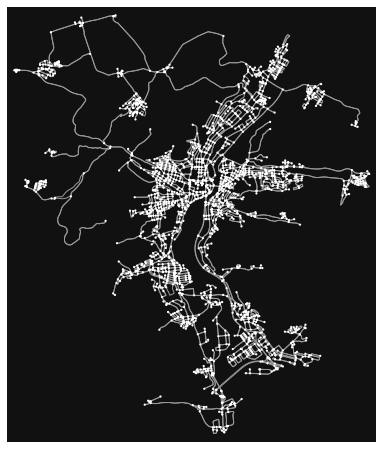

In [2]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Jena, Germany", network_type="drive")
fig, ax = ox.plot_graph(G, node_size=5)

In [3]:
x_index_and_values=list(G.nodes.data("x"))
y_index_and_values=list(G.nodes.data("y"))
Num_Nodes=len(x_index_and_values)


In [4]:
X=np.zeros(2*Num_Nodes)
X=X.reshape(Num_Nodes,2)
for i in range(Num_Nodes):
    X[i,0]=x_index_and_values[i][1]
    X[i,1]=y_index_and_values[i][1]

In [5]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

98249473.52678213

## Kmean


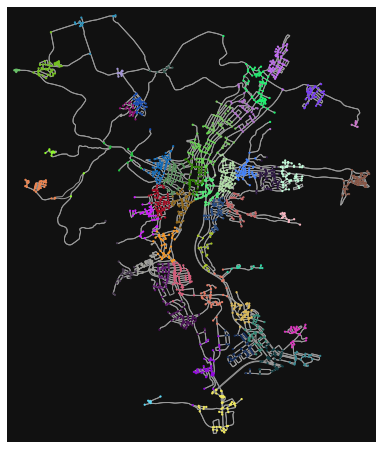

[[11.56502454 50.91993952]
 [11.60795435 50.93271605]
 [11.60579731 50.88380943]
 [11.52215859 50.96109207]
 [11.63741861 50.95357488]
 [11.55764888 50.9494426 ]
 [11.58609496 50.93104589]
 [11.59054229 50.91107275]
 [11.59773406 50.9451235 ]
 [11.51751339 50.9286815 ]
 [11.61357923 50.95543534]
 [11.59728254 50.86739113]
 [11.6256176  50.92004568]
 [11.65623874 50.92973816]
 [11.63256394 50.88113946]
 [11.57210834 50.90316876]
 [11.62722905 50.9317688 ]
 [11.60680735 50.89394081]
 [11.59122759 50.92703892]
 [11.5708644  50.93388466]
 [11.55521036 50.90492964]
 [11.56652035 50.86939838]
 [11.58164493 50.89180156]
 [11.59139136 50.87868692]
 [11.60462478 50.92232587]
 [11.6218676  50.96239037]
 [11.58936532 50.93850959]
 [11.57318664 50.9123973 ]
 [11.57251671 50.96059368]
 [11.53902577 50.97312729]
 [11.58030299 50.92338778]
 [11.61980601 50.88086146]
 [11.59500544 50.92115224]
 [11.57632647 50.93114741]
 [11.60752154 50.94938941]
 [11.56514835 50.90681232]
 [11.57074011 50.92427614]
 

In [6]:
num_labels=50
model=KMeans(num_labels)
model.fit(X)
centers = np.array(model.cluster_centers_)

len(model.labels_)

col_list=[]
for i in range(int(Num_Nodes)):
    random.seed(model.labels_[i])
    col_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))  
fig, ax = ox.plot_graph(G, node_size=5,node_color=col_list)
ax.scatter(centers[:,0], centers[:,1], marker="x", color='r',s=1000)
print(centers)

## Idee für Subgraph Partionierung

Führe KMEAN(100) um Punkte zu Gruppen zusamemnzuführen,
entferne alle Knoten, welche Kannten innerhalb ihres KMEAN Labels haben. 
-Noch unklar: Füge alle Knoten mit Kanten zu anderen Knoten zusammen und der Gewichte

In [7]:
##Alle Kanten einer Node ermitteln
model.labels_
list_of_nodes=list(G.nodes())
NODE=list_of_nodes[10]
for edge in list(G.edges()):
    if(edge[0]==NODE):
        print("links")
        print(edge)
    if(edge[1]==NODE):
        print("rechts")
        print(edge)
        
def edgesofnode(NODE):
    edges=[]
    for edge in list(G.edges()):
        if(edge[0]==NODE):
            edges.append(edge)
        if(edge[1]==NODE):
            edges.append(edge)
    return edges
def edgesofnode_other_node(NODE):
    edges=[]
    for edge in list(G.edges()):
        if(edge[0]==NODE):
            edges.append(edge[1])
        if(edge[1]==NODE):
            edges.append(edge[0])
    return edges


links
(31995540, 31995620)
links
(31995540, 1468410627)
links
(31995540, 2099818856)
rechts
(31995620, 31995540)
rechts
(1468410627, 31995540)
rechts
(2099818856, 31995540)


In [22]:
edgesofnode_other_node(NODE)

[31995620, 1468410627, 2099818856, 31995620, 1468410627, 2099818856]

## Alle Knoten nach Eigenschaft zur Eliminierung (nur Kannten, die innerhalb der Labelgruppe sich bewegen) durchsuchen

In [9]:
H=G

for NODE in list_of_nodes:
    neighbors=edgesofnode_other_node(NODE)
    index_of_NODE=list_of_nodes.index(NODE)
    label_of_NODE=model.labels_[index_of_NODE]
    onlysamelabel=True    
    for neighbor in neighbors:
        if(label_of_NODE!=model.labels_[list_of_nodes.index(neighbor)]):
            onlysamelabel=False
    if onlysamelabel:
        H.remove_node(NODE)


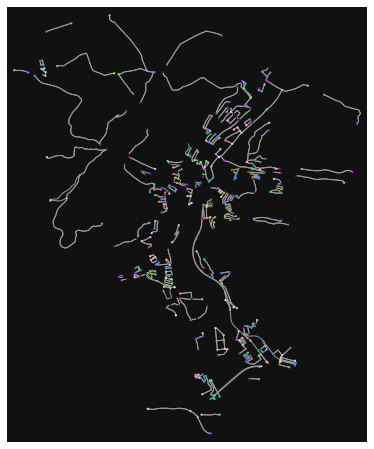

In [10]:
col_list=[]
for i in range(len(list(G.nodes()))):
    random.seed(model.labels_[i])
    col_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))  
fig, ax = ox.plot_graph(G, node_size=5,node_color=col_list)

In [10]:
G = ox.graph_from_place("Jena, Germany", network_type="drive")
print(type((G)))

/home/daniel/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/home/daniel/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/home/daniel/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


<class 'networkx.classes.multidigraph.MultiDiGraph'>


### Problem:
Edges wurden mit entfernt
Such einen Weg edges beizubehalten

In [14]:
for NODE in list_of_nodes[243:253]:## mit 1:10, 11:20 funktionsfähig, 1:20 kernel stirbt.
    neighbors=edgesofnode_other_node(NODE)
    index_of_NODE=list_of_nodes.index(NODE)
    label_of_NODE=model.labels_[index_of_NODE]
    onlysamelabel=True    
    for neighbor in neighbors:
        if(label_of_NODE!=model.labels_[list_of_nodes.index(neighbor)]):
            onlysamelabel=False
    if onlysamelabel: #führt zum Absturz des Programmes
        for neighbor_1 in neighbors:
            for neighbor_2 in neighbors:
                if neighbor_1!=neighbor_2:
                    G.add_edge(neighbor_1,neighbor_2)
        G.remove_node(NODE)        

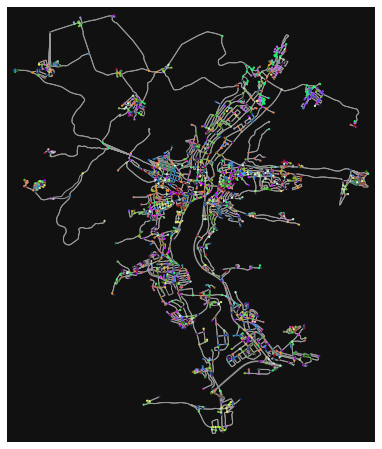

In [15]:
col_list=[]
for i in range(len(list(G.nodes()))):
    random.seed(model.labels_[i])
    col_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))  
fig, ax = ox.plot_graph(G, node_size=5,node_color=col_list)